In [12]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
import cv2
import os

model = tf.keras.models.load_model("/kaggle/input/mainmodel/keras/default/1/densenet121_model.keras")  # Adjust path if needed

def preprocess_image(img_path, target_size=(224, 224)):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.densenet.preprocess_input(img_array)
    return img_array, img

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy(), predictions.numpy()[0][0]

def display_gradcam(img_path, heatmap, pred_prob, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))

    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)

    # Add prediction text
    label = "Autistic" if pred_prob < 0.5 else "Non-Autistic"
    confidence = pred_prob if label == "Non-Autistic" else 1 - pred_prob
    text = f"Pred: {label} ({confidence*100:.1f}%)"
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(superimposed_img, text, (10, 25), font, 0.8, (255, 255, 255), 2)

    # Show plots
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(heatmap, cmap="viridis")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Overlay + Prediction")
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.tight_layout()
    plt.show()



🔍 Processing: /kaggle/input/autism-dataset/train/Non_Autistic.1246.jpg


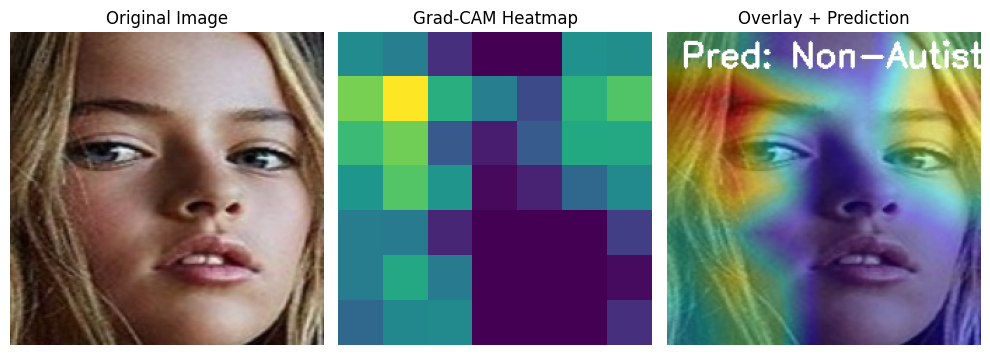


🔍 Processing: /kaggle/input/autism-dataset/train/Autistic.194.jpg


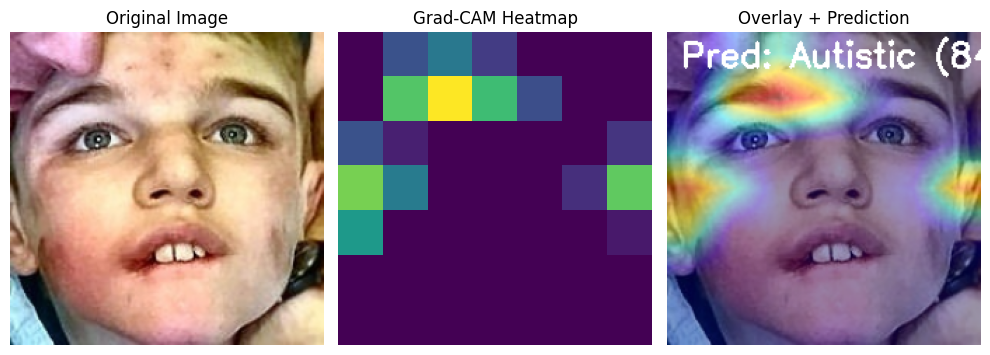


🔍 Processing: /kaggle/input/autism-dataset/train/Non_Autistic.834.jpg


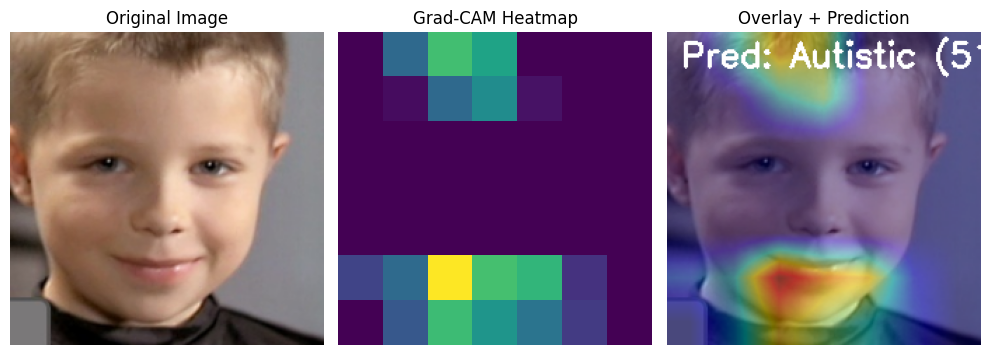


🔍 Processing: /kaggle/input/autism-dataset/train/Autistic.1103.jpg


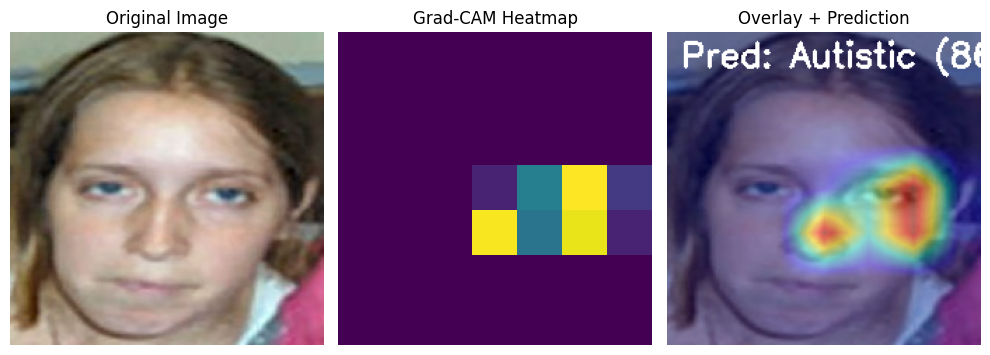

In [14]:
image_paths = [
    "/kaggle/input/autism-dataset/train/Non_Autistic.1246.jpg",
    "/kaggle/input/autism-dataset/train/Autistic.194.jpg",
    "/kaggle/input/autism-dataset/train/Non_Autistic.834.jpg",
    "/kaggle/input/autism-dataset/train/Autistic.1103.jpg"
]

for img_path in image_paths:
    print(f"\n🔍 Processing: {img_path}")
    img_array, original_img = preprocess_image(img_path)

    heatmap, pred_prob = make_gradcam_heatmap(
        img_array,
        model,
        last_conv_layer_name="conv5_block16_concat"
    )

    display_gradcam(img_path, heatmap, pred_prob)
